In [96]:
import rasterio
from shapely.geometry import mapping
import rasterio.mask
import cv2
import rasterio.features
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np

In [52]:
# dark mode for matplotlib
plt.style.use('dark_background')

In [53]:
kilometers_offshore = 100
upper_windspeed = 12
lower_windspeed = 9
population_density_limit = 1000

In [54]:
brazil = gpd.read_file('data/brazil.geojson')
polygon = max(brazil.geometry[0].geoms, key=lambda x: x.area)
offshore = gpd.GeoDataFrame({'geometry': [polygon]}, crs=brazil.crs) \
    .to_crs('EPSG:5880') \
    .buffer(kilometers_offshore * 1000) \
    .to_crs(brazil.crs) \
    .difference(brazil)
brazil_and_offshore = offshore.union(brazil)

offshore.to_file('data/offshore.geojson', driver='GeoJSON')
brazil_and_offshore.to_file('data/offshore_brazil.geojson', driver='GeoJSON')


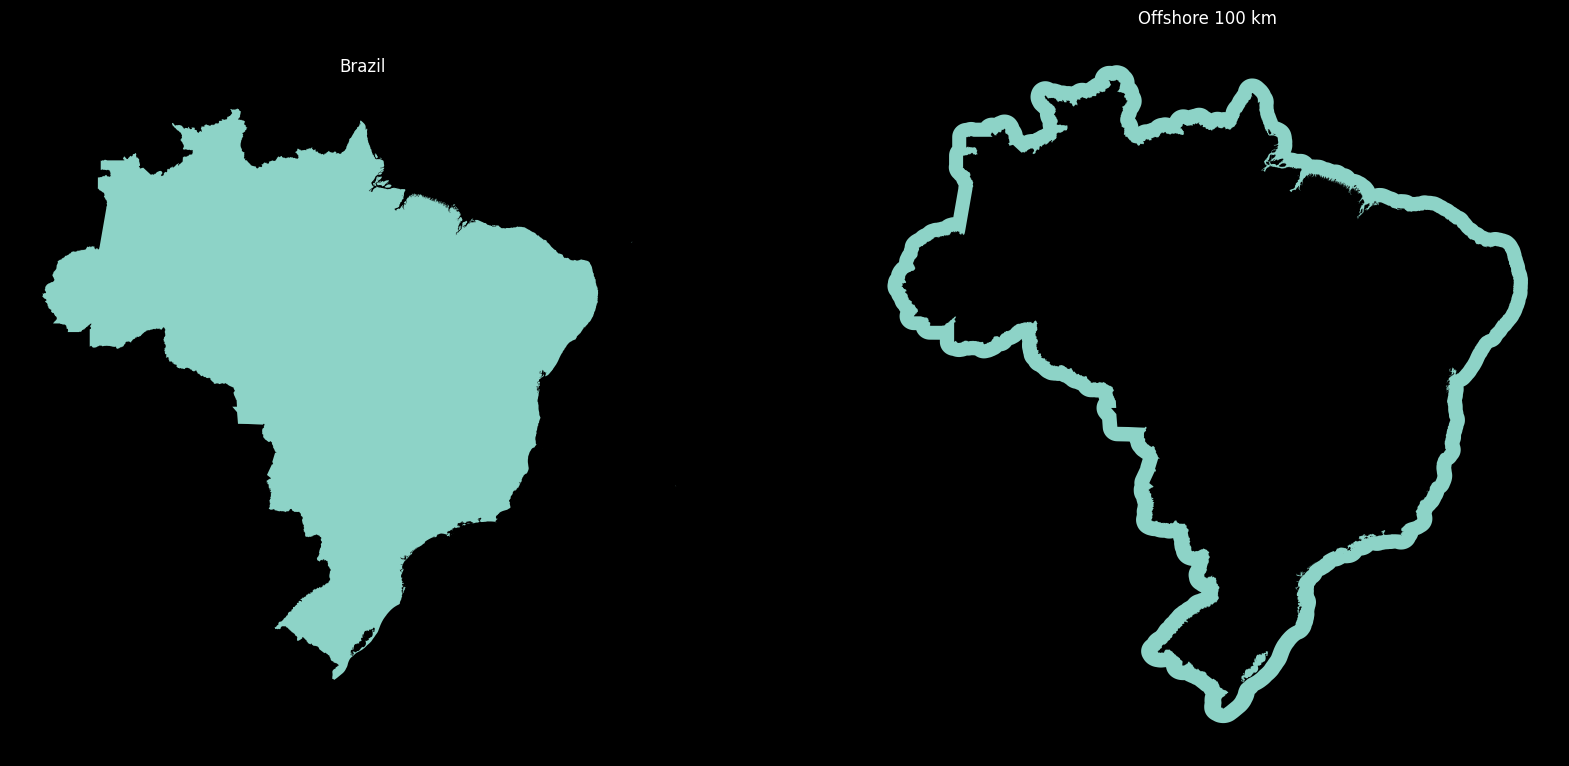

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
brazil.plot(ax=axes[0])
axes[0].set_title('Brazil')
axes[0].set_axis_off()
offshore.plot(ax=axes[1])
axes[1].set_title(f'Offshore {kilometers_offshore} km')
axes[1].set_axis_off()
plt.show()

In [62]:
geometries = [mapping(polygon) for polygon in brazil_and_offshore.geometry]

def get_power_density():
    with rasterio.open('data/gwa3_250_powerdensity_100m.tif') as src:
        power_density, out_transform = rasterio.mask.mask(src, geometries, crop=True)
        power_density = power_density[0]
    return power_density

def get_wind_speed():
    with rasterio.open('data/gwa3_250_windspeed_100m.tif') as src:
        wind_speed, out_transform = rasterio.mask.mask(src, geometries, crop=True)
        wind_speed = wind_speed[0]
    return wind_speed

def get_population_density():
    population_density = pd.read_csv('data/bra_pd_2020_1km_ASCII_XYZ.csv')
    population_density = gpd.GeoDataFrame(population_density['Z'],
        geometry=gpd.points_from_xy(population_density['X'], population_density['Y']))
    return population_density

In [112]:
power_density = get_power_density()
wind_speed = get_wind_speed()
population_density = get_population_density()